In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
tf.enable_eager_execution()

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [3]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [4]:
board_size = 7

# Machine Learning Models
Actor-Critic method

In [5]:
from tensorflow.keras import layers

In [6]:
actor = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Flatten(),
    layers.Softmax(),
    layers.Reshape((board_size, board_size))
])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
critic = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Reshape((board_size, board_size))
])

In [8]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [9]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'ko', 'pass'])):
        plt.subplot(2,2,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

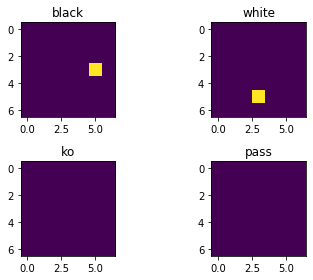

In [10]:
plot_state(state, channels_last=False)

In [11]:
state = state.transpose(1,2,0).reshape(1,7,7,4)

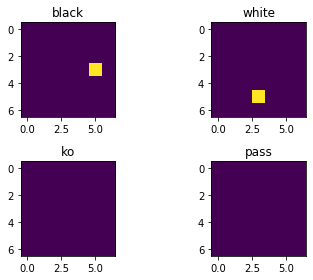

In [12]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [16]:
probs = actor.predict(state)

In [17]:
values = critic.predict(state)

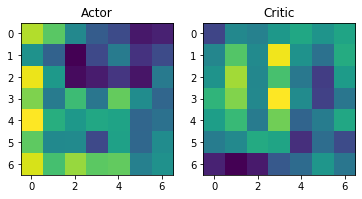

In [18]:
plt.subplot(1,2,1)
plt.title('Actor')
plt.imshow(probs[0])
plt.subplot(1,2,2)
plt.title('Critic')
plt.imshow(values[0])

# Training Setup

# Train

# Evaluate